In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction import FeatureHasher


In [2]:
# Section 2: Dataset Access and Overview
# ---------------------------------------
# In this section, we access the small dataset, perform an overview, and extract key information.

# Define the path to the small dataset
small_data_path = 'Combined_Flights_small.csv'

# Load the small dataset into a Pandas DataFrame
small_data = pd.read_csv(small_data_path)

# Display general information about the dataset
print("Column Names:")
print(small_data.columns.tolist())
print("\nData Types:")
print(small_data.dtypes)
print("\nMissing Values:")
print(small_data.isnull().sum())
print("\nNumber of Unique Values:")
print(small_data.nunique())
print("\nTarget Variable Distribution:")
print(small_data['Disruption'].value_counts())

Column Names:
['Unnamed: 0', 'FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'CRSDepTime', 'CRSElapsedTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepTimeBlk', 'CRSArrTime', 'ArrDel15', 'ArrTimeBlk', 'DistanceGroup', 'Disruption']

Data Types:
Unnamed: 0                                   int64
FlightDate                                  object
Airline                       

In [3]:
# Section 3: Data Cleaning and Preprocessing
# ------------------------------------------

# Drop unnecessary columns including 'Unnamed: 0', 'Cancelled', 'Diverted', 'ArrDel15'
columns_to_drop = ['Unnamed: 0', 'Cancelled', 'Diverted', 'ArrDel15']
small_data.drop(columns=columns_to_drop, inplace=True)

# Identify features and target variable
X = small_data.drop('Disruption', axis=1)
y = small_data['Disruption']

# Separate categorical and numeric features
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Handling missing values in categorical features
X[categorical_features] = X[categorical_features].fillna('Unknown')

# Create transformers for preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


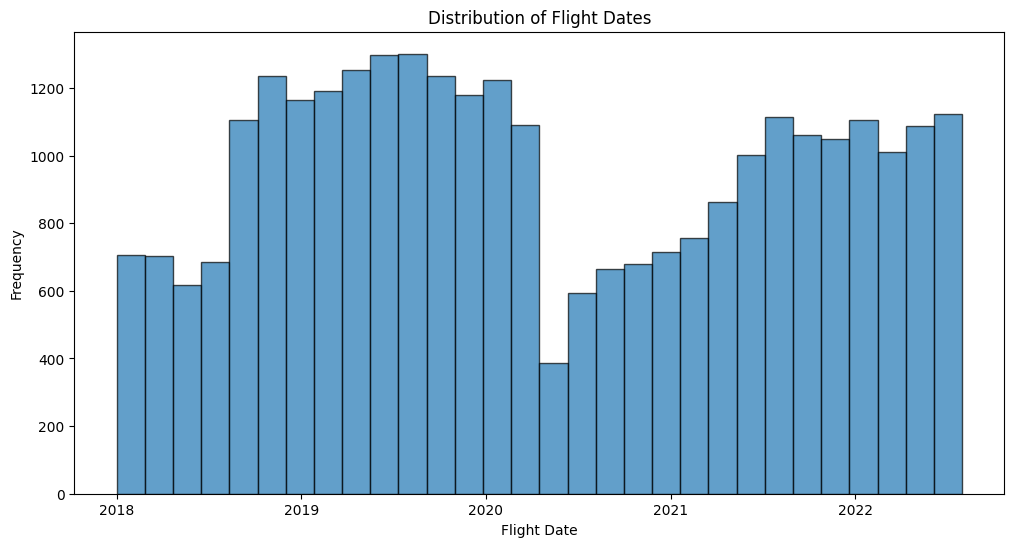

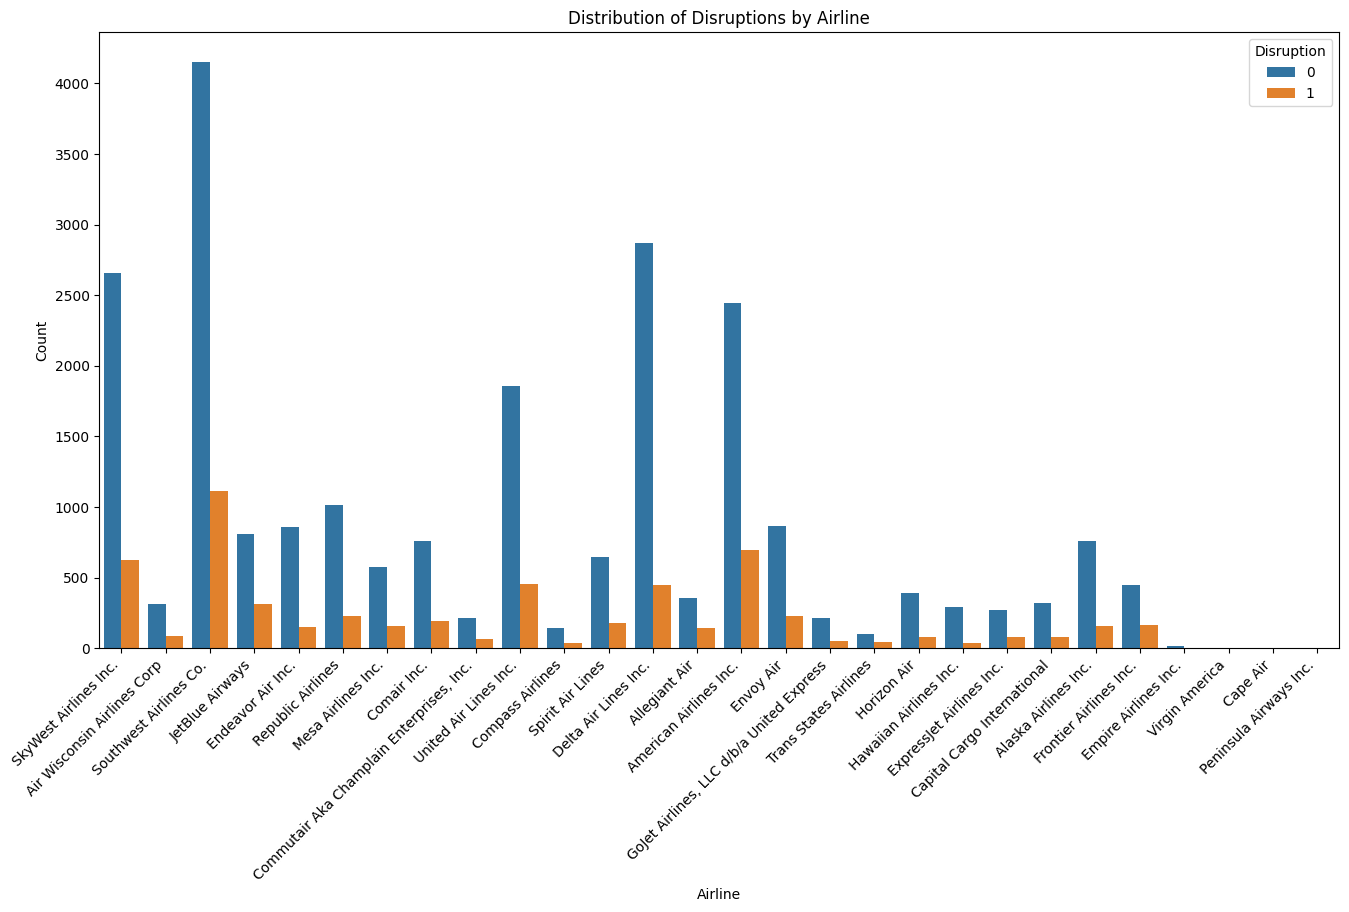

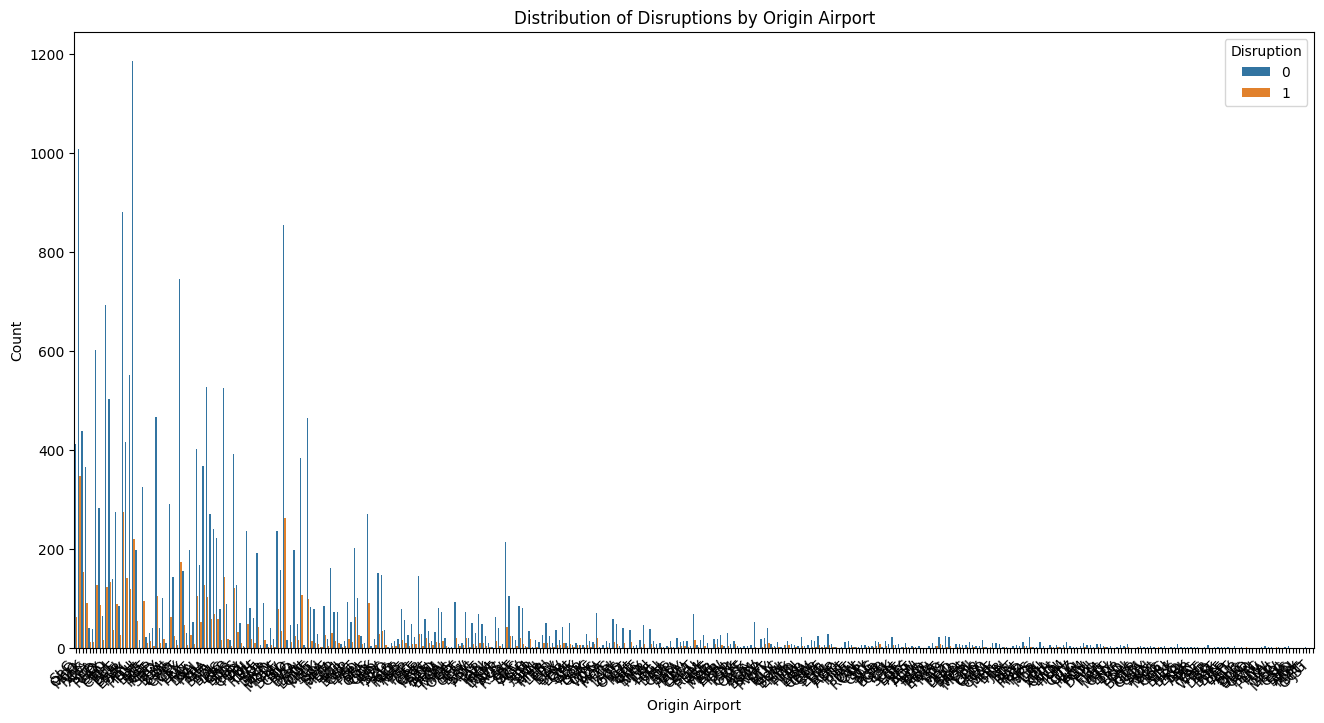

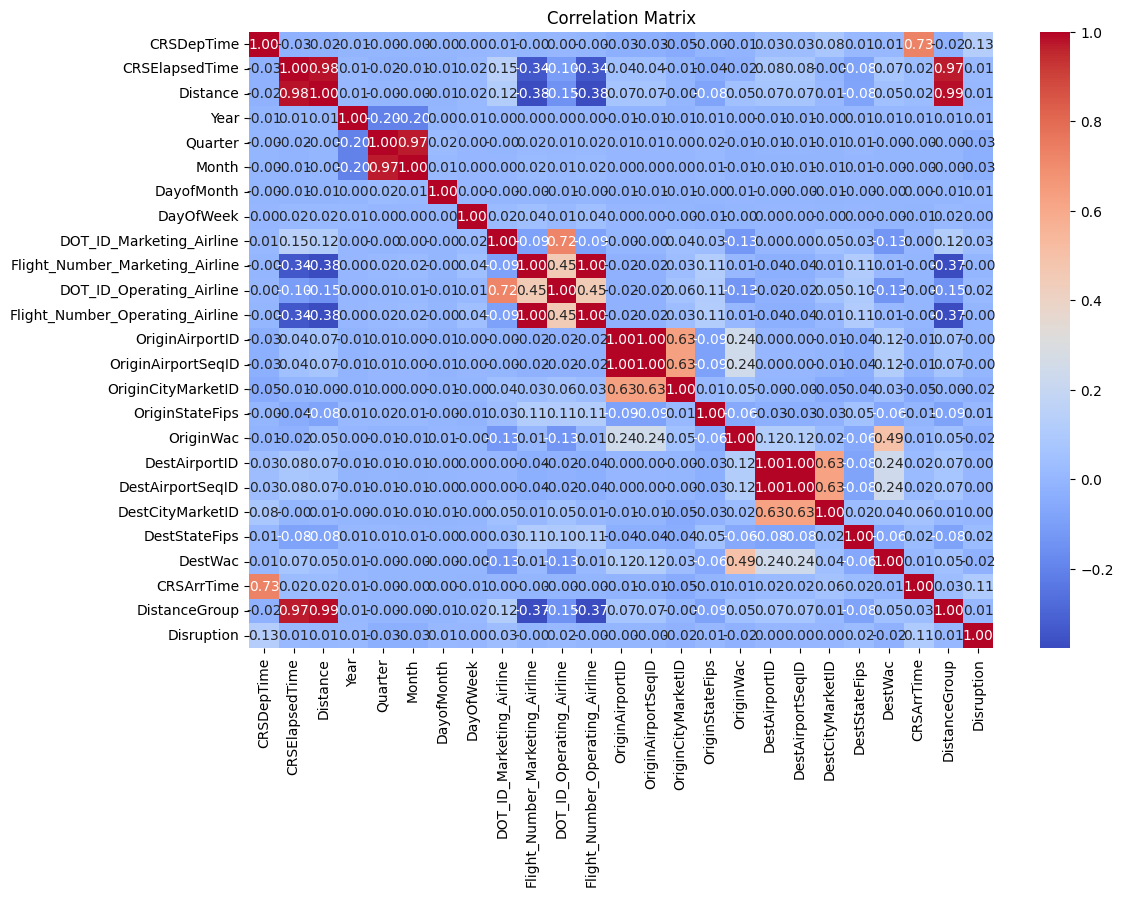

In [4]:
# Section 4: Exploratory Data Analysis (EDA)
# -----------------------------------------

# Visualize the distribution of flight dates
plt.figure(figsize=(12, 6))
plt.hist(pd.to_datetime(small_data['FlightDate']), bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Flight Dates')
plt.xlabel('Flight Date')
plt.ylabel('Frequency')
plt.show()

# Analyzing Categorical Variables

# Visualizing the distribution of 'Airline' with respect to 'Disruption'
plt.figure(figsize=(16, 8))
sns.countplot(x='Airline', hue='Disruption', data=small_data)
plt.title('Distribution of Disruptions by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Visualizing the distribution of 'Origin' with respect to 'Disruption'
plt.figure(figsize=(16, 8))
sns.countplot(x='Origin', hue='Disruption', data=small_data)
plt.title('Distribution of Disruptions by Origin Airport')
plt.xlabel('Origin Airport')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Correlation Analysis (for numeric variables)
numeric_columns = small_data.select_dtypes(include=['number']).columns
correlation_matrix = small_data[numeric_columns].corr()

# Visualizing the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [5]:
# Section 5: Feature Selection
# ----------------------------

# Select only numeric columns for correlation calculation
numeric_columns = small_data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = small_data[numeric_columns].corr()

# Set a threshold for strong correlation
correlation_threshold = 0.7

# Select pairs of correlated features
correlated_pairs = (correlation_matrix.abs() > correlation_threshold) & (correlation_matrix < 1)

# Create a list to store correlated pairs
correlated_pairs_list = []

for feature_1 in correlated_pairs.columns:
    for feature_2 in correlated_pairs.index:
        if correlated_pairs.loc[feature_2, feature_1]:
            correlated_pairs_list.append({
                'Feature_1': feature_1,
                'Feature_2': feature_2,
                'Correlation': correlation_matrix.loc[feature_2, feature_1]
            })

# Create a DataFrame from the list of correlated pairs
correlated_pairs_df = pd.DataFrame(correlated_pairs_list, columns=['Feature_1', 'Feature_2', 'Correlation'])

# Drop one feature from each correlated pair
for index, row in correlated_pairs_df.iterrows():
    if row['Correlation'] > 0.7:  # Adjust the threshold as needed
        # Drop one of the features in the pair if it exists in X and is not 'CRSDepTime'
        feature_to_drop = row['Feature_1'] if row['Correlation'] > correlated_pairs_df.loc[index, 'Correlation'] else row['Feature_2']
        if feature_to_drop in X.columns :
            X = X.drop(feature_to_drop, axis=1)

# Display the resulting features after dropping correlated ones
print("Selected Features after Correlation-Based Feature Selection:")
print(X.columns)




Selected Features after Correlation-Based Feature Selection:
Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Year', 'DayofMonth',
       'DayOfWeek', 'Marketing_Airline_Network',
       'Operated_or_Branded_Code_Share_Partners',
       'IATA_Code_Marketing_Airline', 'Operating_Airline',
       'IATA_Code_Operating_Airline', 'Tail_Number', 'OriginCityMarketID',
       'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName',
       'OriginWac', 'DestCityMarketID', 'DestCityName', 'DestState',
       'DestStateFips', 'DestStateName', 'DestWac', 'DepTimeBlk',
       'ArrTimeBlk'],
      dtype='object')


In [10]:
# Section 6: Model Selection and Training
# ----------------------------------------

# Selecting a subset of features for training
selected_features = [
    'FlightDate', 'Airline', 'Origin', 'Dest', 'Year', 'DayofMonth',
    'DayOfWeek', 'Marketing_Airline_Network', 'Operating_Airline', 'Tail_Number'
]

# Subset the data with selected features and create a copy to avoid SettingWithCopyWarning
X_selected = X[selected_features].copy()

# Replace 'reference_date' with the actual reference date or a specific date in the correct format
reference_date = pd.to_datetime('2020-01-01')

# Convert 'FlightDate' to numerical format (number of days since a reference date)
X_selected['FlightDate'] = (pd.to_datetime(X_selected['FlightDate']) - reference_date).dt.days

# Handle missing values for categorical features
categorical_features_selected = X_selected.select_dtypes(include=['object']).columns
X_selected[categorical_features_selected] = X_selected[categorical_features_selected].fillna('Unknown')

# Apply the hashing trick for one-hot encoding
hashing_encoder = FeatureHasher(n_features=10, input_type='string')
hashed_features = hashing_encoder.transform(X_selected[categorical_features_selected].astype(str).apply(lambda x: [x])).toarray()

# Combine hashed features with numeric features
X_encoded = np.hstack((X_selected.drop(categorical_features_selected, axis=1).to_numpy(), hashed_features))

# Perform stratified sampling for train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# List of models
models = [('Random Forest', rf_model), ('Logistic Regression', lr_model), ('XGBoost', xgb_model)]

# Train and evaluate each model
for model_name, model in models:
    print(f"Training {model_name}...")
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # Display results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report_str)
    print("Confusion Matrix:\n", confusion_mat)
    print("\n" + "="*50 + "\n")


ValueError: Samples can not be a single string. The input must be an iterable over iterables of strings.